# Training ReLU One-Neuron Models

This code is for training 100,000 one-neuron models with varying levels of sparsity and different loss functions. The differences in loss functions is described in the replication paper found <a href="https://github.com/zroe1/toy_models_of_superposition/blob/main/FINDINGS.pdf">here.</a>

In [15]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
import warnings
from torch import nn

In [16]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = get_device()
print(f"Using {device} device")

Using mps device


In [17]:
class ManyToyModels(nn.Module):
    def __init__(self, m, n, num_models, include_ReLU):
        '''Create a toy model

        Args:
            m (int): the number of neurons (as described in original paper)
            n (int): the number of features the Toy model can map.
            (The weight matrix is delcared to be m * n)

            include_ReLU (bool): if True, a nonlinearity is added to the network
        '''
        super().__init__()
        self.weights = nn.Parameter(torch.randn(num_models, m, n) * 1.5, requires_grad=True)
        self.bias = nn.Parameter(torch.randn(num_models, n, 1) * 0.5, requires_grad=True)
        self.ReLU = nn.ReLU(inplace=True)
        self.inclue_ReLU = include_ReLU

    def forward(self, x):
        hidden = self.weights @ x
        final = torch.transpose(self.weights, -2, -1) @ hidden
        final += self.bias
        if self.inclue_ReLU:
            return self.ReLU(final)
        else:
            return final

class MSE_Multiple_models(nn.Module):
    def __init__(self):
        super(MSE_Multiple_models, self).__init__()

    def forward(self, predictions, targets, importance):
        sub_total = ((predictions - targets)**2).sum(0)
        return torch.sum(sub_total * importance)

In [18]:
sparsity_rows = 1000
importance_rows = 100
probs = torch.repeat_interleave((torch.arange(0, sparsity_rows) / sparsity_rows), 2 * importance_rows)
probs = probs.reshape(sparsity_rows * importance_rows, 1, 2)

def train_1000_models(model, num_models, epochs, total_batchs, batch_size, loss_fn, optimizer, importance):

    model.train()
    loss_total = 0
    for epoch in range(epochs):
        for i in range(total_batchs):
            # calculating sparsity based on model
            rand_tensor = torch.rand(sparsity_rows * importance_rows, 1, 2)
            sparsity_tensor = (probs > rand_tensor).float()

            x = torch.rand(batch_size, num_models, 2, 1)
            x = (x*sparsity_tensor).to(device)
            pred = model(x)
            loss = loss_fn(pred, x, importance)
            loss_total += loss.item()  / (total_batchs * batch_size)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("(EPOCH:", str(epoch + 1) + ")", "--> loss:", loss_total)
        loss_total = 0

## Training 100,000 One-Neuron ReLU Models

In [19]:
model_test = ManyToyModels(1, 2, 100000, True).to(device)

In [20]:
NUM_EPOCHS = 6
BATCHS_PER_EPOCH = 1000
BATCH_SIZE = 64
LEARNING_RATE = 1e-2

In [21]:
first_feature_importance = torch.ones(100000, 1)
second_feature_importance = ((torch.arange(100)).repeat(1000, 1) / 10).reshape(100000, 1)
IMPORTANCE = torch.stack((first_feature_importance, second_feature_importance), dim=1).to(device)

In [23]:
weights_total = None
NUM_MODELS_TO_AVG_OVER = 10

for i in range(NUM_MODELS_TO_AVG_OVER):
  model_test = ManyToyModels(1, 2, 100000, True).to(device)
  optimizer = torch.optim.Adam(model_test.parameters(), lr=LEARNING_RATE)
  loss_func = MSE_Multiple_models()
  num_models = 100000

  train_1000_models(model_test, num_models, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE)
  # w = model_test.weights.to('cpu')

  w = model_test.weights.to('cpu').reshape(1000, 100, 1, 2)

  if weights_total is None:
    weights_total = [w]
  else:
    weights_total.append(w)

  print("*" * 50)

(EPOCH: 1) --> loss: 245705.2817851561
(EPOCH: 2) --> loss: 39223.08166796875
(EPOCH: 3) --> loss: 34123.73390429686
(EPOCH: 4) --> loss: 31683.03798242184
(EPOCH: 5) --> loss: 30337.919716796867
(EPOCH: 6) --> loss: 29573.83727148439
**************************************************
(EPOCH: 1) --> loss: 255647.09587890652
(EPOCH: 2) --> loss: 39794.02270312497
(EPOCH: 3) --> loss: 34726.279933593745
(EPOCH: 4) --> loss: 32295.809681640647
(EPOCH: 5) --> loss: 30937.214037109363
(EPOCH: 6) --> loss: 30166.45762695311
**************************************************
(EPOCH: 1) --> loss: 246156.64471093766
(EPOCH: 2) --> loss: 39392.51835156255
(EPOCH: 3) --> loss: 34350.718603515634
(EPOCH: 4) --> loss: 31920.517179687486
(EPOCH: 5) --> loss: 30546.185976562538
(EPOCH: 6) --> loss: 29744.95558789068
**************************************************
(EPOCH: 1) --> loss: 250382.6378515623
(EPOCH: 2) --> loss: 39873.45719921876
(EPOCH: 3) --> loss: 34688.636535156234
(EPOCH: 4) --> los

## Graphing the Results

In [79]:
w_avgs = None
for weights in weights_total:
    measured_losses = torch.zeros(1000, 100)
    model_first_feature = ((torch.abs(weights[:,:,:, :1]) > 0.8) & (torch.abs(weights[:,:,:, 1:2]) < 0.2)).squeeze()
    model_second_feature = ((torch.abs(weights[:,:,:, :1]) < 0.2) & (torch.abs(weights[:,:,:, 1:2]) > 0.8)).squeeze()
    measured_losses[model_first_feature] = 1
    measured_losses[model_second_feature] = -1

    if w_avgs == None:
        w_avgs = measured_losses
    else:
        w_avgs += measured_losses

In [83]:
model_first_feature = (w_avgs > 5).squeeze() # mapped by 1
model_second_feature = (w_avgs < -5).squeeze() # mapped by -1

In [84]:
avgs_graph= torch.zeros(1000, 100)
avgs_graph[model_first_feature] = 1
avgs_graph[model_second_feature] = -1

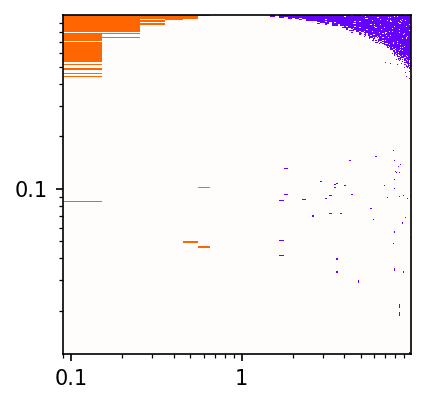

In [85]:
warnings.filterwarnings('ignore')

plt.figure(figsize=(3, 3), dpi=150)

# Set the x-axis to a logarithmic scale
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

colors = [(.4, 0, 1), (1, 1, 1), (1, .4, 0)]  # Purple -> White -> Orange
n_bins = 100
cm = LinearSegmentedColormap.from_list("", colors, N=n_bins)

plt.imshow(avgs_graph, cmap=cm, aspect='auto')

# Get current y-ticks
current_yticks = plt.gca().get_yticks()

plt.gca().invert_yaxis()
plt.gca().set_xticklabels(['', '', '0.1', '1', '10', '', ''])
plt.gca().set_yticklabels(['', '', '0.1', '0.1', ''])

plt.show()